In [16]:
# Add DEVENV_PATH to the path so that we can import the modules
import sys
from os import getenv

import pendulum
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns

from entrypoint import load_gin
load_gin("ingest-kafka", test=False)
import greenflow.analysis as an
from greenflow.utils import convert_to_mib

cutoff_begin = "2024-12-16T03:15:35.626996+01:00"
# cutoff_end = '2025-02-12T00:07:45.003699+01:00'
cutoff_end = pendulum.now().to_iso8601_string()

load_gin(exp_name="ingest-kafka", test=False)
# cutoff_end

from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from tinydb import TinyDB, Query
from os import getenv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
import greenflow.analysis as an

df = an.full_analytical_pipeline_nocache(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    # cluster=".*",
    cluster="taurus",
    # type="scalingBehaviour",
    replicationFactor=3,
    broker_replicas=3,
    # load=0,
    # load=10**9,
    # type=".*",
    messageSize=32,
    # type="igdle"
    # durationSeconds=300,
    type="proportionality",
)
# experiments = an.get_experiments()
# redpanda_kafka_data = an.filter_experiments(
#     experiments,
#     an.interest(cluster="ovhnvme", type="memImpact"),
#     cutoff_begin=cutoff_begin,
#     cutoff_end=cutoff_end,
# )
# df = df[df["load"] != 0]
df.dropna()
df = df[df["load"] != 50000]
df = df[df["observed_throughput"] != 100]
df = df[df["broker_cpu"] == 8]
df = df[df["broker_mem"] == "16Gi"]
df["unit_power"] = df["average_power"] / df["num_broker_nodes"]

# df = df[df["partitions"] != 1]
# df = df[df["producer_instances"] != 1]
# df = df[df["partitions"] >= 100]
# df = df[df["broker_replicas"] == 3]
an.create_qgrid_widget(df)

Running calculation: calculate_observed_throughput
Running calculation: calculate_average_power
Running calculation: calculate_throughput_MBps
Running calculation: calculate_throughput_per_watt
Running calculation: calculate_energy_cost


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

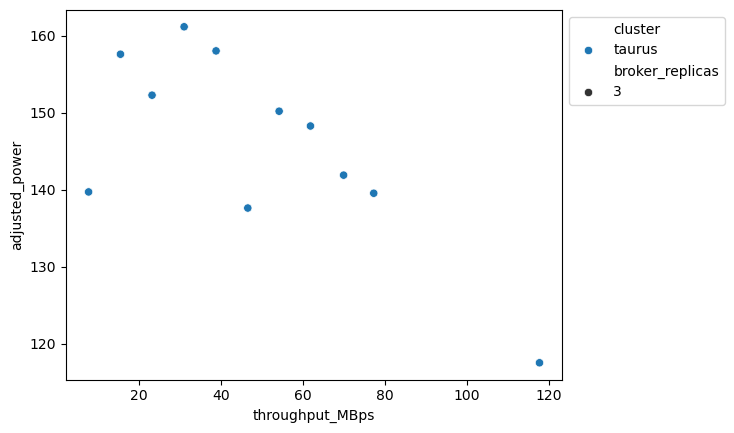

In [18]:
kafka = df[df["exp_name"] == "ingest-kafka"]
redpanda = df[df["exp_name"] == "ingest-redpanda"]
x = "throughput_MBps"
y = "adjusted_power"
ax = sns.scatterplot(
    data=kafka,
    x=x,
    y=y,
    hue="cluster",
    style="broker_replicas",
    # size="broker_replicas",
    # sizes=(50, 200)
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# sns.FacetGrid(df, col="cluster", hue="exp_name", col_wrap=3).map(
#     sns.scatterplot, "throughput_MBps", "adjusted_power"
# ).add_legend()

ValueError: Axes(0.125,0.11;0.775x0.77) has no legend attached.

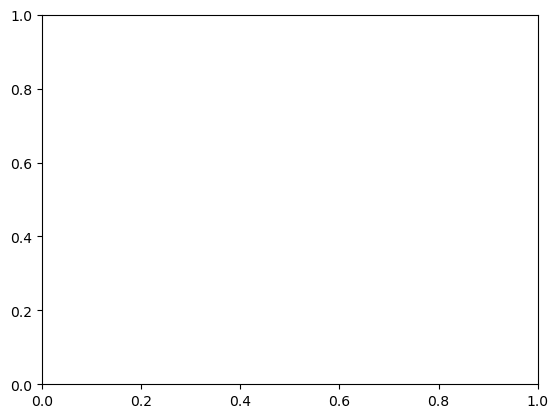

In [19]:
ax = sns.scatterplot(
    data=redpanda,
    x=x,
    y=y,
    hue="cluster",
    style="broker_replicas",
    # size="broker_replicas",
    # sizes=(50, 200)
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<Axes: xlabel='observed_throughput', ylabel='adjusted_power'>

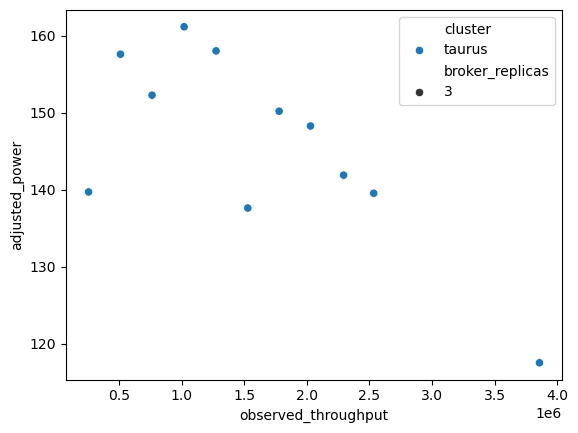

In [20]:
sns.scatterplot(data=df, x="observed_throughput", y="adjusted_power", hue="cluster", style="broker_replicas")